#THE CODE FOR NLS STARTS HERE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
data_class1 = np.load('/content/drive/MyDrive/Group13/nls_group13/NLS_C1_train.npy')
data_class2 = np.load('/content/drive/MyDrive/Group13/nls_group13/NLS_C2_train.npy')

data_test1   = np.load('/content/drive/MyDrive/Group13/nls_group13/NLS_C1_test.npy')
data_test2   = np.load('/content/drive/MyDrive/Group13/nls_group13/NLS_C2_test.npy')

data = []

In [3]:
def func_G(x,cov, mean,p=1/3):
    inv_cov = np.linalg.pinv(cov)
    g = -0.5*np.matmul(np.matmul((x-mean),(inv_cov)),((x-mean).T))-0.5*(np.log(np.linalg.det(cov)))+np.log(p)-np.log(2.0*np.pi)
    if(isinstance(g,np.ndarray)):
        return g.diagonal()
    else:
        return g

In [4]:
def find_mean(data):
    return [np.sum(data[:,0])/data.shape[0],np.sum(data[:,1])/data.shape[0]]

def find_covariance(data, mean):
    a = []
    varx = (np.sum(data[:,0]**2)/data.shape[0])-(mean[0]**2)
    vary = (np.sum(data[:,1]**2)/data.shape[0])-(mean[1]**2)
    varxy = (np.sum(data[:,0]*data[:,1])/data.shape[0])-(mean[0]*mean[1])
    a = [[varx,varxy],[varxy,vary]]
    a = np.array(a)

    return a

In [6]:
def get_confusion_mat(classes, il=None,jl=None):

    lis = []
    if((il != None) and (jl!=None)):
        conf_mat = np.full((2,2),1e-10)
        for i in range(data_test1.shape[0]):
            lis.append(0)
        for i in range(data_test2.shape[0]):
            lis.append(1)
        for i in range(len(classes)):
            conf_mat[lis[i]][classes[i]]+=1
        return np.array(conf_mat)
    else:
        conf_mat = np.full((2,2),1e-10)
        if(il==1 and jl==2):
            for i in range(data_test1.shape[0]):
                lis.append(0)
            for i in range(data_test2.shape[0]):
                lis.append(1)
        for i in range(len(classes)):
            conf_mat[lis[i]][classes[i]]+=1

        return np.array(conf_mat)

In [7]:
def metric(conf_matrix):
    x = conf_matrix.shape[0]
    precision = []
    accuracy = []
    recall = []
    f_measure = []
    total_sum = np.sum(conf_matrix)
    for i in range(x):
        TP = conf_matrix[i][i]
        FN = np.sum(conf_matrix[i,:])-conf_matrix[i][i]
        FP = np.sum(conf_matrix[:,i])-conf_matrix[i][i]
        TN = total_sum-(TP+FP+FN)

        recal = TP/(TP+FN)
        preci = TP/(TP+FP)
        acc = (TP+TN)/(TP+TN+FP+FN)

        precision.append(preci)
        recall.append(recal)
        accuracy.append(acc)
        f_measure.append((2*recal*preci)/(recal+preci))

    return accuracy,precision,recall,f_measure

In [8]:
def find_range(data1, data2, test):

    minx = np.min(data1[:,0])
    minx = min(minx, np.min(data2[:,0]))

    miny = np.min(data1[:,1])
    miny = min(miny, np.min(data2[:,1]))

    maxx = np.max(data1[:,0])
    maxx = max(maxx, np.max(data2[:,0]))

    maxy = np.min(data1[:,1])
    maxy = max(maxy, np.max(data2[:,1]))
    scalex = maxx-minx
    scaley = maxy-miny

    return minx-5, miny-5, maxx+5, maxy+5

In [21]:
def pair_plot(data, dc1, dc2,cov1, cov2, mean1, mean2, il, jl):
    dat_blue = []
    dat_red = []
    dict_={1:'aquamarine',2:'lightsalmon',3:'thistle'}
    dict_2 = {1:'red',2:'green',3:'blue'}
    patch1 = mpatches.Patch(color=dict_[il], label='class{}'.format(il))
    patch2 = mpatches.Patch(color=dict_[jl], label='class{}'.format(jl))
    for i in (range(data.shape[0])):
        g1 = func_G(data[i],cov1,mean1)
        g2 = func_G(data[i],cov2,mean2)
        if(np.argmax([g1,g2])==0):
            dat_red.append([data[i][0],data[i][1]])
        elif(np.argmax([g1,g2])==1):
            dat_blue.append([data[i][0],data[i][1]])

    dat_blue = np.array(dat_blue)
    dat_red = np.array(dat_red)
    fig, ax = plt.subplots()

    minx1 = (mean1[0])-10
    miny1 = (mean1[1])-10
    maxx1 = (mean1[0])+10
    maxy1 = (mean1[1])+10

    minx2 = (mean2[0])-10
    miny2 = (mean2[1])-10
    maxx2 = (mean2[0])+10
    maxy2 = (mean2[1])+10
    x1 = np.linspace(minx1,maxx1,500)
    y1 = np.linspace(miny1,maxy1,500)
    n1 = 500
    Z1 = np.ndarray(shape=(n1,n1),dtype=float)
    for i in range(n1):
        for j in range(n1):
            P = [[x1[i],y1[j]]]
            P = np.array(P)
            g = func_G(P,cov1,mean1)
            Z1[j][i]=np.e**g[0]
    X1, Y1 = np.meshgrid(x1,y1)
    x2 = np.linspace(minx2,maxx2,500)
    y2 = np.linspace(miny2,maxy2,500)
    n2 = 500
    Z2 = np.ndarray(shape=(n2,n2),dtype=float)
    print(cov1)
    for i in range(n2):
        for j in range(n2):
            P = [[x2[i],y2[j]]]
            P = np.array(P)
            g = func_G(P,cov2,mean2)
            Z2[j][i]=np.e**g[0]
    X2, Y2 = np.meshgrid(x2,y2)


    ax = plt.scatter(dat_blue[:,0], dat_blue[:,1], s=2, c=dict_[jl])
    ax = plt.scatter(dat_red[:,0], dat_red[:,1], s=2, c=dict_[il])
    ax = plt.legend(handles=[patch2,patch1])
    ax = plt.scatter(dc1[:,0], dc1[:,1], s=2, c=dict_2[il])
    ax = plt.scatter(dc2[:,0], dc2[:,1], s=2, c=dict_2[jl])
    plt.show()

    fig, ax2 = plt.subplots()
    ax2 = plt.contour(X1, Y1, Z1, colors='black')
    ax2 = plt.contour(X2, Y2, Z2, colors='red')
    ax2 = plt.scatter(dat_blue[:,0], dat_blue[:,1], s=2, c=dict_[jl])
    ax2 = plt.scatter(dat_red[:,0], dat_red[:,1], s=2, c=dict_[il])
    ax2 = plt.legend(handles=[patch2,patch1])
    ax2 = plt.scatter(dc1[:,0], dc1[:,1], s=2, c=dict_2[il])
    ax2 = plt.scatter(dc2[:,0], dc2[:,1], s=2, c=dict_2[jl])
    plt.show()


    data_test = []
    if(il==1 or jl==1):
        for i in range(data_test1.shape[0]):
            data_test.append([data_test1[i][0],data_test1[i][1]])
    if(il==2 or jl==2):
        for i in range(data_test2.shape[0]):
            data_test.append([data_test2[i][0],data_test2[i][1]])
    if(il==3 or jl==3):
        for i in range(data_test3.shape[0]):
            data_test.append([data_test3[i][0],data_test3[i][1]])

    data_test = np.array(data_test)
    g1 = func_G(data_test, cov1, mean1)
    g2 = func_G(data_test, cov2, mean2)

    classes = []
    for i in range(data_test.shape[0]):
        classes.append(np.argmax([g1[i],g2[i]]))

    conf_mat = get_confusion_mat(classes, il,jl)
    print("Confusion Matrix")
    print(conf_mat)
    temp = np.array(metric(conf_mat))
    print("Accuracy: ",temp[0,:])
    print("Precision: ",temp[1,:])
    print("Recall: ",temp[2,:])
    print("F-Measure: ",temp[3,:])
    print("Mean F-Measure: ",np.mean(temp[3,:]))

'''
def total_plot(data,cov1, cov2, cov3, mean1, mean2, mean3):

    dat_blue = []
    dat_red = []
    dat_green = []
    aquamarine_patch = mpatches.Patch(color='aquamarine', label='class1')
    lightsalmon_patch = mpatches.Patch(color='lightsalmon', label='class2')
    thistle_patch = mpatches.Patch(color='thistle', label='class3')
    for i in (range(data.shape[0])):
        g1 = func_G(data[i],cov1,mean1)
        g2 = func_G(data[i],cov2,mean2)
        g3 = func_G(data[i],cov3,mean3)
        if(np.argmax([g1,g2,g3])==0):
            dat_red.append([data[i][0],data[i][1]])
        elif(np.argmax([g1,g2,g3])==1):
            dat_blue.append([data[i][0],data[i][1]])
        elif(np.argmax([g1,g2,g3])==2):
            dat_green.append([data[i][0],data[i][1]])

    dat_blue = np.array(dat_blue)
    dat_red = np.array(dat_red)
    dat_green = np.array(dat_green)

    fig, ax = plt.subplots()
    ax = plt.scatter(dat_blue[:,0], dat_blue[:,1], s=2, c='aquamarine')
    ax = plt.scatter(dat_red[:,0], dat_red[:,1], s=2, c='lightsalmon')
    ax = plt.scatter(dat_green[:,0], dat_green[:,1], s=2, c='thistle')
    ax = plt.legend(handles=[aquamarine_patch,lightsalmon_patch,thistle_patch])
    ax = plt.scatter(data_class1[:,0], data_class1[:,1], s=2, c='blue')
    ax = plt.scatter(data_class2[:,0], data_class2[:,1], s=2, c='green')
    ax = plt.scatter(data_class3[:,0], data_class3[:,1], s=2, c='red')
    plt.show()

    minx1 = (mean1[0])-10
    miny1 = (mean1[1])-10
    maxx1 = (mean1[0])+10
    maxy1 = (mean1[1])+10

    minx2 = (mean2[0])-10
    miny2 = (mean2[1])-10
    maxx2 = (mean2[0])+10
    maxy2 = (mean2[1])+10

    minx3 = (mean3[0])-10
    miny3 = (mean3[1])-10
    maxx3 = (mean3[0])+10
    maxy3 = (mean3[1])+10



    x1 = np.linspace(minx1,maxx1,500)
    y1 = np.linspace(miny1,maxy1,500)
    n1 = 500
    Z1 = np.ndarray(shape=(n1,n1),dtype=float)
    for i in range(n1):
        for j in range(n1):
            P = [[x1[i],y1[j]]]
            P = np.array(P)
            g = func_G(P,cov1,mean1)
            Z1[j][i]=np.e**g[0]
    X1, Y1 = np.meshgrid(x1,y1)

    x2 = np.linspace(minx2,maxx2,500)
    y2 = np.linspace(miny2,maxy2,500)
    n2 = 500
    Z2 = np.ndarray(shape=(n2,n2),dtype=float)
    print(cov1)
    for i in range(n2):
        for j in range(n2):
            P = [[x2[i],y2[j]]]
            P = np.array(P)
            g = func_G(P,cov2,mean2)
            Z2[j][i]=np.e**g[0]
    X2, Y2 = np.meshgrid(x2,y2)

    x3 = np.linspace(minx3,maxx3,500)
    y3 = np.linspace(miny3,maxy3,500)
    n3 = 500
    Z3 = np.ndarray(shape=(n3,n3),dtype=float)
    print(cov2)
    for i in range(n3):
        for j in range(n3):
            P = [[x3[i],y3[j]]]
            P = np.array(P)
            g = func_G(P,cov3,mean3)
            Z3[j][i]=np.e**g[0]
    X3, Y3 = np.meshgrid(x3,y3)
    print(cov3)

    fig3, ax3 = plt.subplots()
    ax3 = plt.contour(X1, Y1, Z1, colors='black')
    ax3 = plt.contour(X2, Y2, Z2, colors='red')
    ax3 = plt.contour(X3, Y3, Z3, colors='green')
    ax3 = plt.scatter(dat_blue[:,0], dat_blue[:,1], s=2, c='aquamarine')
    ax3 = plt.scatter(dat_red[:,0], dat_red[:,1], s=2, c='lightsalmon')
    ax3 = plt.scatter(dat_green[:,0], dat_green[:,1], s=2, c='thistle')
    ax3 = plt.legend(handles=[aquamarine_patch,lightsalmon_patch,thistle_patch])
    ax3 = plt.scatter(data_class1[:,0], data_class1[:,1], s=2, c='blue')
    ax3 = plt.scatter(data_class2[:,0], data_class2[:,1], s=2, c='green')
    ax3 = plt.scatter(data_class3[:,0], data_class3[:,1], s=2, c='red')
    plt.show()

    data_test = []
    for i in range(data_test1.shape[0]):
        data_test.append([data_test1[i][0],data_test1[i][1]])
    for i in range(data_test2.shape[0]):
        data_test.append([data_test2[i][0],data_test2[i][1]])
    for i in range(data_test3.shape[0]):
        data_test.append([data_test3[i][0],data_test3[i][1]])

    data_test = np.array(data_test)

    g1 = func_G(data_test, cov1, mean1)
    g2 = func_G(data_test, cov2, mean2)
    g3 = func_G(data_test, cov3, mean3)


    classes = []
    for i in range(data_test.shape[0]):
        classes.append(np.argmax([g1[i],g2[i],g3[i]]))

    conf_mat = get_confusion_mat(classes,1,2,3)
    print(conf_mat)
    temp = np.array(metric(conf_mat))
    print("Accuracy: ",temp[0,:])
    print("Precision: ",temp[1,:])
    print("Recall: ",temp[2,:])
    print("F-Measure: ",temp[3,:])
    print("Mean F-Measure: ",np.mean(temp[3,:]))
'''

'\ndef total_plot(data,cov1, cov2, cov3, mean1, mean2, mean3):\n\n    dat_blue = []\n    dat_red = []\n    dat_green = []\n    aquamarine_patch = mpatches.Patch(color=\'aquamarine\', label=\'class1\')\n    lightsalmon_patch = mpatches.Patch(color=\'lightsalmon\', label=\'class2\')\n    thistle_patch = mpatches.Patch(color=\'thistle\', label=\'class3\')\n    for i in (range(data.shape[0])):\n        g1 = func_G(data[i],cov1,mean1)\n        g2 = func_G(data[i],cov2,mean2)\n        g3 = func_G(data[i],cov3,mean3)\n        if(np.argmax([g1,g2,g3])==0):\n            dat_red.append([data[i][0],data[i][1]])\n        elif(np.argmax([g1,g2,g3])==1):\n            dat_blue.append([data[i][0],data[i][1]])\n        elif(np.argmax([g1,g2,g3])==2):\n            dat_green.append([data[i][0],data[i][1]])\n\n    dat_blue = np.array(dat_blue)\n    dat_red = np.array(dat_red)\n    dat_green = np.array(dat_green)\n\n    fig, ax = plt.subplots()\n    ax = plt.scatter(dat_blue[:,0], dat_blue[:,1], s=2, c=\'a

In [22]:

data_test = []
for i in range(data_test1.shape[0]):
    data_test.append([data_test1[i][0],data_test1[i][1]])
for i in range(data_test2.shape[0]):
    data_test.append([data_test2[i][0],data_test2[i][1]])

data_test = np.array(data_test)
minx, miny, maxx,maxy = find_range(data_class1, data_class2, data_test)
print(minx,miny,maxx,maxy)

data = []
for i in np.arange(minx,maxx,0.15):
    for j in np.arange(miny,maxy,0.15):
        data.append([i,j])
data = np.array(data)
print(data.shape[0])


-18.2 -17.0 19.2 18.0
58500


In [23]:
mean11 = find_mean(data_class1)
mean22 = find_mean(data_class2)
mean11 = np.array(mean11)
mean22 = np.array(mean22)

cov11 = find_covariance(data_class1, mean11)
cov22 = find_covariance(data_class2, mean22)

cov11 = np.array(cov11)
cov22 = np.array(cov22)


##ALL HAVE SAME DIAGONAL MATRIX

[[31.26534939  0.        ]
 [ 0.         31.26534939]]


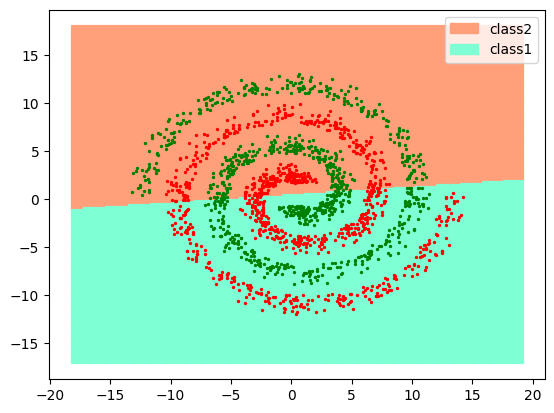

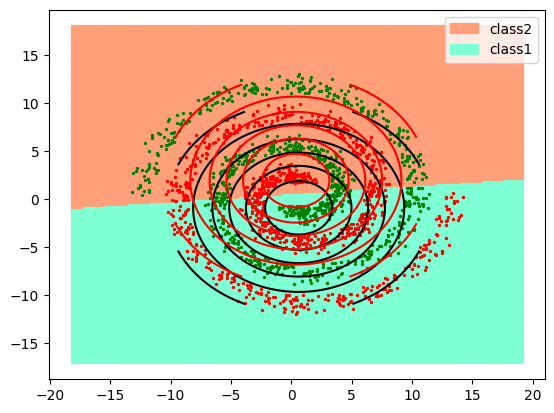

Confusion Matrix
[[201. 190.]
 [190. 201.]]
Accuracy:  [0.5140665 0.5140665]
Precision:  [0.5140665 0.5140665]
Recall:  [0.5140665 0.5140665]
F-Measure:  [0.5140665 0.5140665]
Mean F-Measure:  0.5140664961636757


In [24]:
var_avg = (cov11[0][0]+cov22[0][0]+cov11[1][1]+cov22[1][1])/4
cov_new = [[var_avg,0],
           [0,var_avg]]


cov_new = np.array(cov_new)
pair_plot(data, data_class1, data_class2, cov_new, cov_new, mean11, mean22,1,2)


## WHEN ALL HAVE SAME COVARIANCE MATRIX

[[33.11325812 -3.699574  ]
 [-3.699574   29.41744066]]


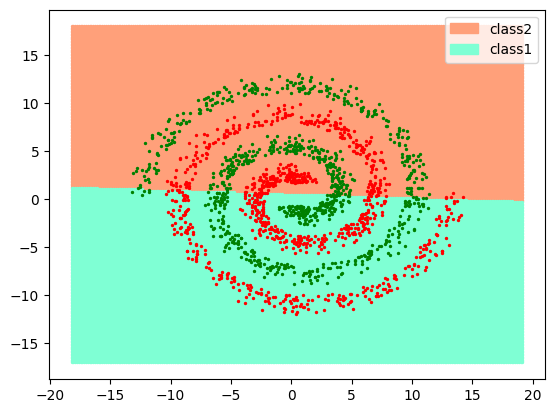

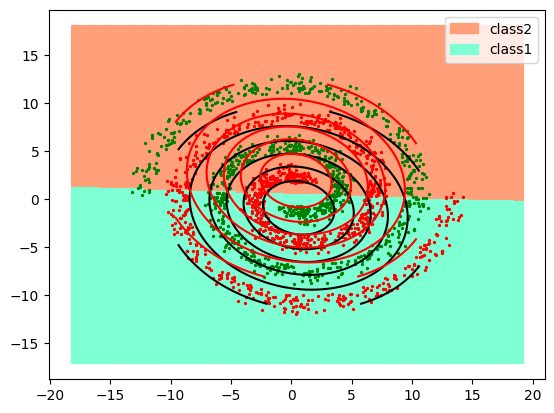

Confusion Matrix
[[201. 190.]
 [190. 201.]]
Accuracy:  [0.5140665 0.5140665]
Precision:  [0.5140665 0.5140665]
Recall:  [0.5140665 0.5140665]
F-Measure:  [0.5140665 0.5140665]
Mean F-Measure:  0.5140664961636757


In [27]:
cov_new = np.add(cov11,cov22)/2
pair_plot(data, data_class1, data_class2, cov_new, cov_new, mean11, mean22,1,2)


## ALL CLASSES HAVE DIFFERENT COVARIANCE MATRIX BUT ARE DIAGONAL

[[33.11745712  0.        ]
 [ 0.         29.41740523]]


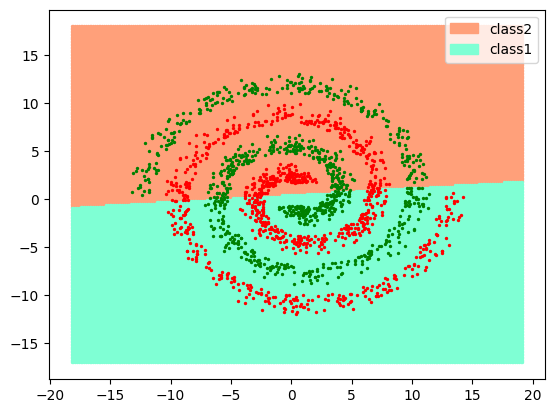

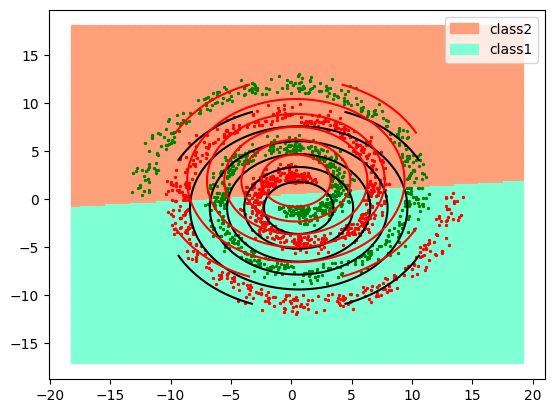

Confusion Matrix
[[202. 189.]
 [189. 202.]]
Accuracy:  [0.51662404 0.51662404]
Precision:  [0.51662404 0.51662404]
Recall:  [0.51662404 0.51662404]
F-Measure:  [0.51662404 0.51662404]
Mean F-Measure:  0.5166240409207076


In [28]:
cov1_new = np.copy(cov11)
cov2_new = np.copy(cov22)
cov1_new[0][1]=0
cov1_new[1][0]=0
cov2_new[0][1]=0
cov2_new[1][0]=0

pair_plot(data, data_class1, data_class2, cov1_new, cov2_new, mean11, mean22,1,2)

## ALL CLASSES WITH DIFFERENT COVARIANCE MATRICES

[[33.11745712 -3.70008494]
 [-3.70008494 29.41740523]]


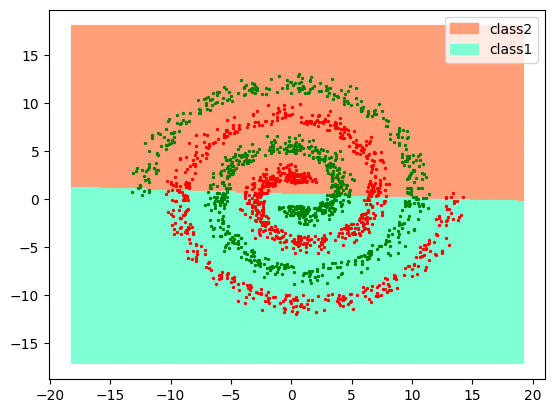

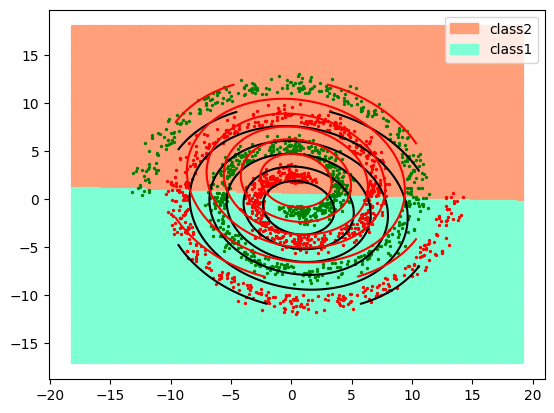

Confusion Matrix
[[201. 190.]
 [190. 201.]]
Accuracy:  [0.5140665 0.5140665]
Precision:  [0.5140665 0.5140665]
Recall:  [0.5140665 0.5140665]
F-Measure:  [0.5140665 0.5140665]
Mean F-Measure:  0.5140664961636757


In [29]:
pair_plot(data, data_class1, data_class2, cov11, cov22, mean11, mean22,1,2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the .npy file
data = np.load('/content/drive/MyDrive/Group13/LS_Group13/Class3_test.npy')

# Check the shape of the data (assuming it's 2D)
print("Shape of the data:", data.shape)

Shape of the data: (125, 2)
